In [127]:
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import csv
plt.style.use('dark_background')

# Section 1 - Square Chirps to Estimate ToF

## Variable Setup

The below variables are all givens, the user defines fL, fH, and tc, and f0 comes from the timer clock.

In [128]:
f0 = 19e6 # timer frequency
fL = 20e3 # lower chirp frequency
fH = 30e3 # upper chirp frequency
tc = 2e-3 # chirp duration

And, some other useful constants:

In [129]:
favg = (fH + fL) / 2.0
fgap = fH - fL
tL = 1 / fL
tH = 1/ fH

Total number of timer counts during one period of the square chirp.

In [130]:
ct = int(tc * f0)
print(ct)

38000


Solving for parameters N (total number of frequency changes), and i (the increment amount between frequencies).

In [131]:
N = int(tc * favg)
i = (tH - tL) * f0 / (tc * favg)
print(N, i)

50 -6.333333333333334


But how many counts will we need at each increment? There's a function for that.

In [132]:
c0 = tL * f0
cN = tH * f0

def c(n):
    if n >= 0 and n <= N:
        return c0 + i*n
    return -1

print(c0, cN)

950.0 633.3333333333334


## Square Chirp Setup

Now, let's piece together a square wave using the above functions:

number of points in generated chirp: 39700


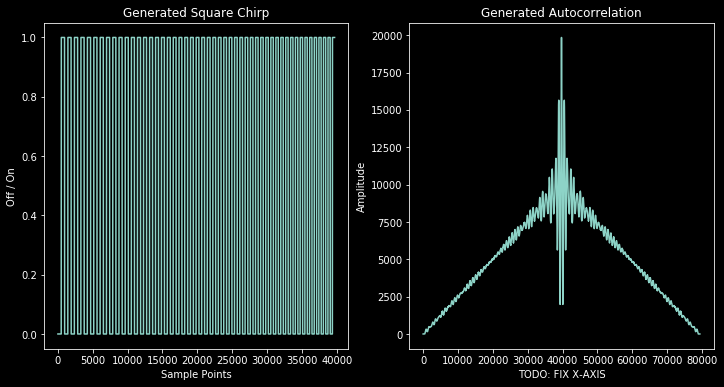

In [133]:
sqwave = []
#39741.666
for n in range(N):
    cn = int(c(n))
    zers = np.zeros(cn//2)
    ones = np.ones (cn//2)
    sqwave = np.concatenate((sqwave, zers, ones), axis=None)
    
print("number of points in generated chirp:", len(sqwave))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(sqwave)
axs[0].set_xlabel("Sample Points")
axs[0].set_ylabel("Off / On")
axs[0].set_title("Generated Square Chirp")
axs[1].plot(np.correlate(sqwave, sqwave, "full"))
axs[1].set_xlabel("TODO: FIX X-AXIS")
axs[1].set_ylabel("Amplitude")
axs[1].set_title("Generated Autocorrelation")
plt.show()

## Sampled Square Chirp Setup

The only problem with this is that we'll never actually have that many data points for our recorded chirp, because we record using the PDM microphones at a different frequency. So let's sample this generated waveform.

In [134]:
fsamp = 19e6 / (32 * 6)
samp_num = int(tc * fsamp)
samp_time = np.linspace(0, 1000 * samp_num / fsamp, samp_num)
samp_sqwave = scipy.signal.resample(sqwave, samp_num)
print("number of points in sampled chirp:", len(samp_sqwave))

number of points in sampled chirp: 197


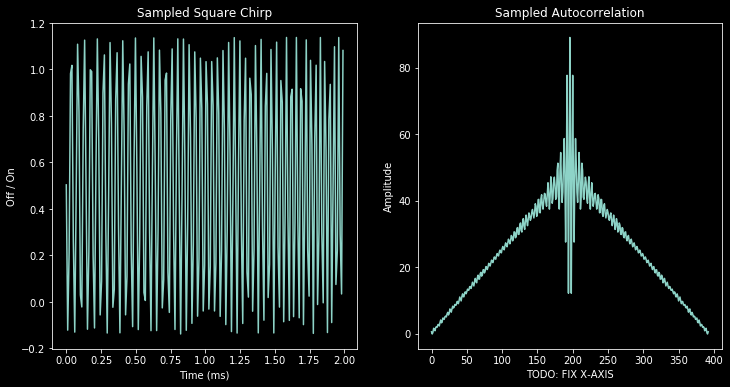

In [135]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(samp_time, samp_sqwave)
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Off / On")
axs[0].set_title("Sampled Square Chirp")
axs[1].plot(np.correlate(samp_sqwave, samp_sqwave, "full"))
axs[1].set_xlabel("TODO: FIX X-AXIS")
axs[1].set_ylabel("Amplitude")
axs[1].set_title("Sampled Autocorrelation")
plt.show()

In [136]:
def butter_highpass_filter(data, cutoff, fs, order=4):
    fnyq = fs / 2
    cutoff_n = cutoff / fnyq
    b, a = signal.butter(order, cutoff_n, btype='high', analog=False)
    return signal.filtfilt(b, a, data)

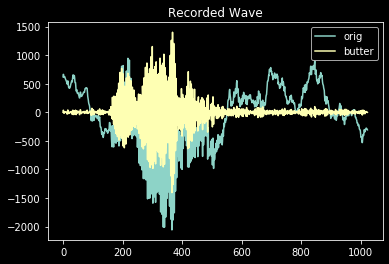

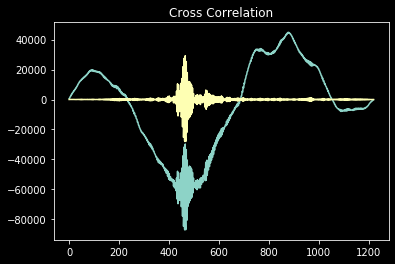

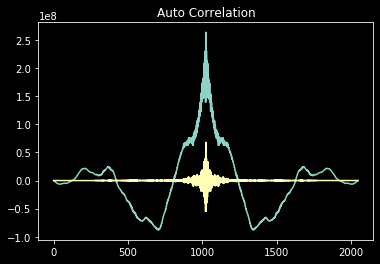

In [137]:
reader = None
recwaveL, recwaveR = [], []

with open("listen.csv", "r") as csvfile:
    reader = csv.reader(csvfile)
    recwaveL = np.array(next(reader))
    recwaveR = np.array(next(reader))
    recwaveL = np.array(next(reader))
    recwaveR = np.array(next(reader))
    recwaveL = np.array(next(reader))
    recwaveR = np.array(next(reader))

csvfile.close()

recwaveL  = np.array(list(map(int, recwaveL)))
recwaveR  = np.array(list(map(int, recwaveR)))
recwaveLF = butter_highpass_filter(recwaveL, 10e3, fsamp)
recwaveRF = butter_highpass_filter(recwaveR, 10e3, fsamp)


plt.plot(recwaveL, label="orig")
plt.plot(recwaveLF, label="butter")
plt.legend()
plt.title("Recorded Wave")
plt.show()
plt.plot(np.correlate(recwaveL , samp_sqwave, "full"))
plt.plot(np.correlate(recwaveLF, samp_sqwave, "full"))
plt.title("Cross Correlation")
plt.show()
plt.plot(np.correlate(recwaveL, recwaveL, "full"))
plt.plot(np.correlate(recwaveLF, recwaveLF, "full"))
plt.title("Auto Correlation")
plt.show()

## Averaging CSV Data for a Hopefully Better Result

[ 303.   309.   309.9 ...  -97.6 -117.2 -116. ]
[ 248.9  260.   281.4 ... -102.9 -108.3 -121.2]


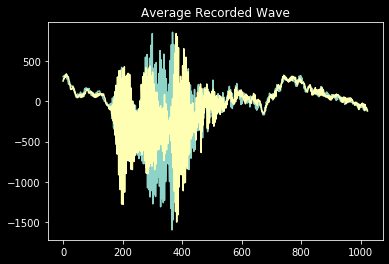

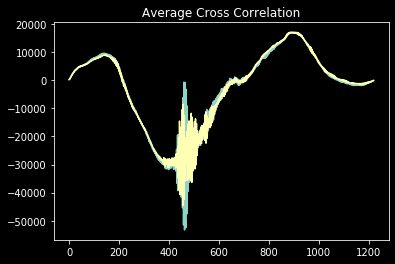

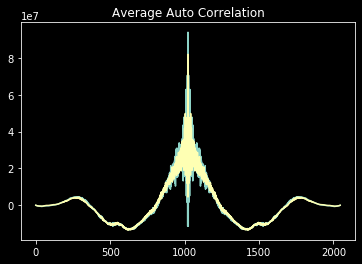

In [139]:
reader = None
recwaveL, recwaveR = np.zeros(1024), np.zeros(1024)

with open("listen.csv", "r") as csvfile:
    reader = csv.reader(csvfile)
    left = True
    for row in reader:
        inArr = np.array(list(map(int, np.array(row))))
        if left:
            recwaveL = np.add(recwaveL, inArr)
        else:
            recwaveR = np.add(recwaveR, inArr)
        left = not left
    
csvfile.close()
recwaveL /= 10
recwaveR /= 10

print(recwaveL)
print(recwaveR)
plt.plot(recwaveL)
plt.plot(recwaveR)
plt.title("Average Recorded Wave")
plt.show()
# plt.plot(scipy.fft.fft(recwaveL))
# plt.plot(scipy.fft.fft(recwaveR))
# plt.show()
plt.plot(np.correlate(recwaveL, samp_sqwave, "full"))
plt.plot(np.correlate(recwaveR, samp_sqwave, "full"))
plt.title("Average Cross Correlation")
plt.show()
plt.plot(np.correlate(recwaveL, recwaveL, "full"))
plt.plot(np.correlate(recwaveR, recwaveR, "full"))
plt.title("Average Auto Correlation")
plt.show()

# Section 2 - Modifying Square Chirp Parameters

The below section serves to highlight how changing the square chirp's parameters change the autocorrelation.

In [140]:
for n in range(N):
    cn = int(c(n))
    zers = np.zeros(cn//2)
    ones = np.ones (cn//2)
    sqwave = np.concatenate((sqwave, zers, ones), axis=None)
    
def square_chirp(f0, fL, fH, tc):
    favg = (fH + fL) / 2.0
    tL, tH = 1 / fL, 1 / fH
    ct = int(tc * f0)
    N  = int(tc * favg)
    i  = (tH - tL) * f0 / (tc * favg)
    c0 = tL * f0
    def c(n):
        if n >= 0 and n <= N:
            return c0 + i*n
        return -1
    sqwave = []
    for n in range(N):
        cn = int(c(n))
        zers = np.zeros(cn//2)
        ones = np.ones (cn//2)
        sqwave = np.concatenate((sqwave, zers, ones), axis=None)
    return sqwave

## Modifying the Frequency Gap

Using the generated, not sampled square wave, let's take a look at the effects the frequency gap has on the autocorrelation. All waveforms below end at 30 kHz.

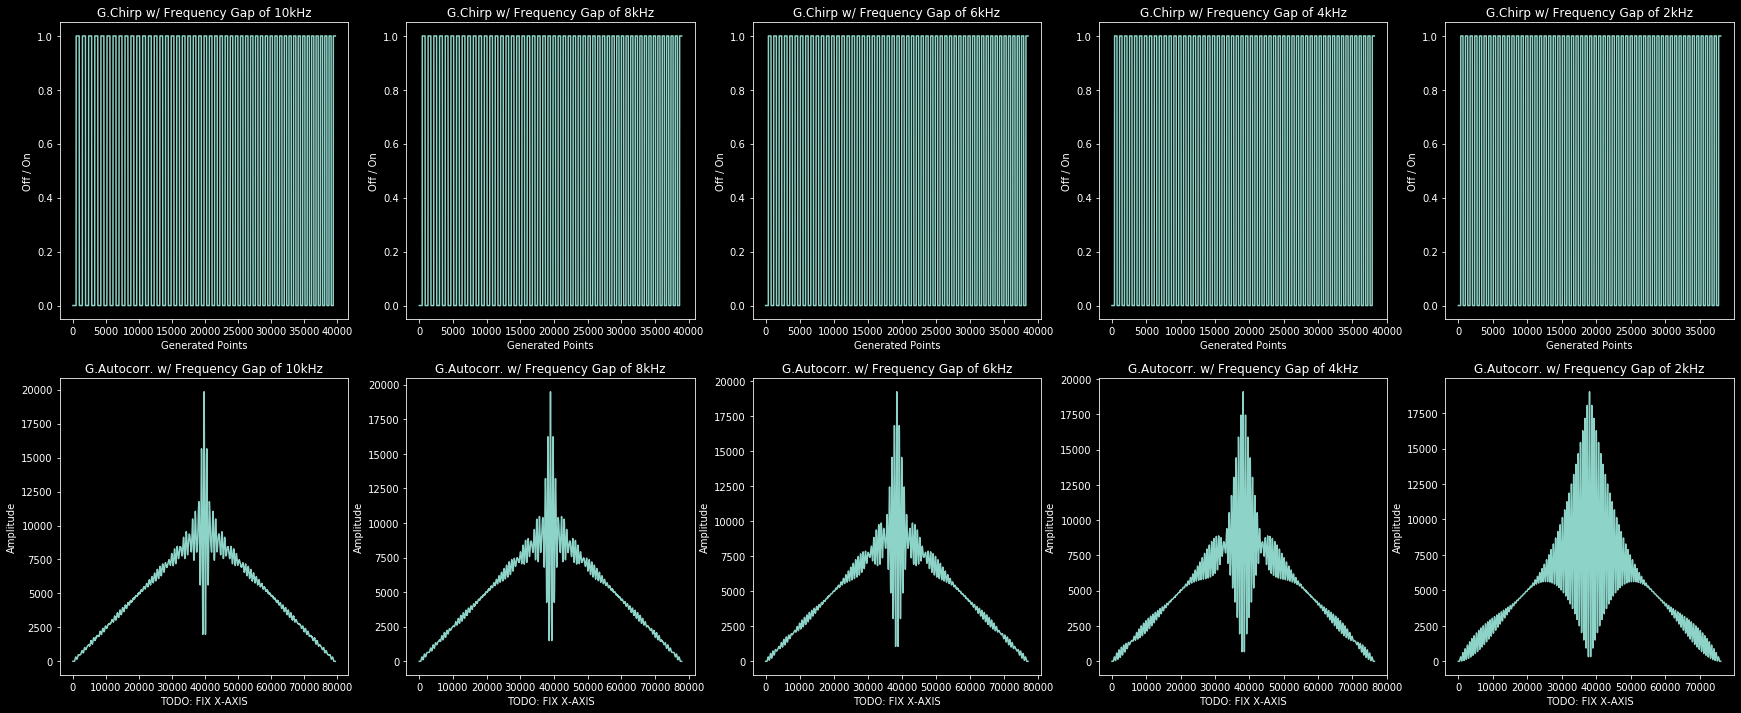

In [141]:
fig, axs = plt.subplots(2, 5, figsize=(30, 12))

for i in range(5):
    fl = 2e3*i + 20e3
    sqwave = square_chirp(19e6, fl, 30e3, 2e-3)
    axs[0, i].plot(sqwave)
    axs[0, i].set_xlabel("Generated Points")
    axs[0, i].set_ylabel("Off / On")
    axs[0, i].set_title("G.Chirp w/ Frequency Gap of " +  str(10 - 2*i) + "kHz")
    axs[1, i].plot(np.correlate(sqwave, sqwave, "full"))
    axs[1, i].set_xlabel("TODO: FIX X-AXIS")
    axs[1, i].set_ylabel("Amplitude")
    axs[1, i].set_title("G.Autocorr. w/ Frequency Gap of " +  str(10 - 2*i) + "kHz")
plt.show()

## Modifying the Chirp Duration

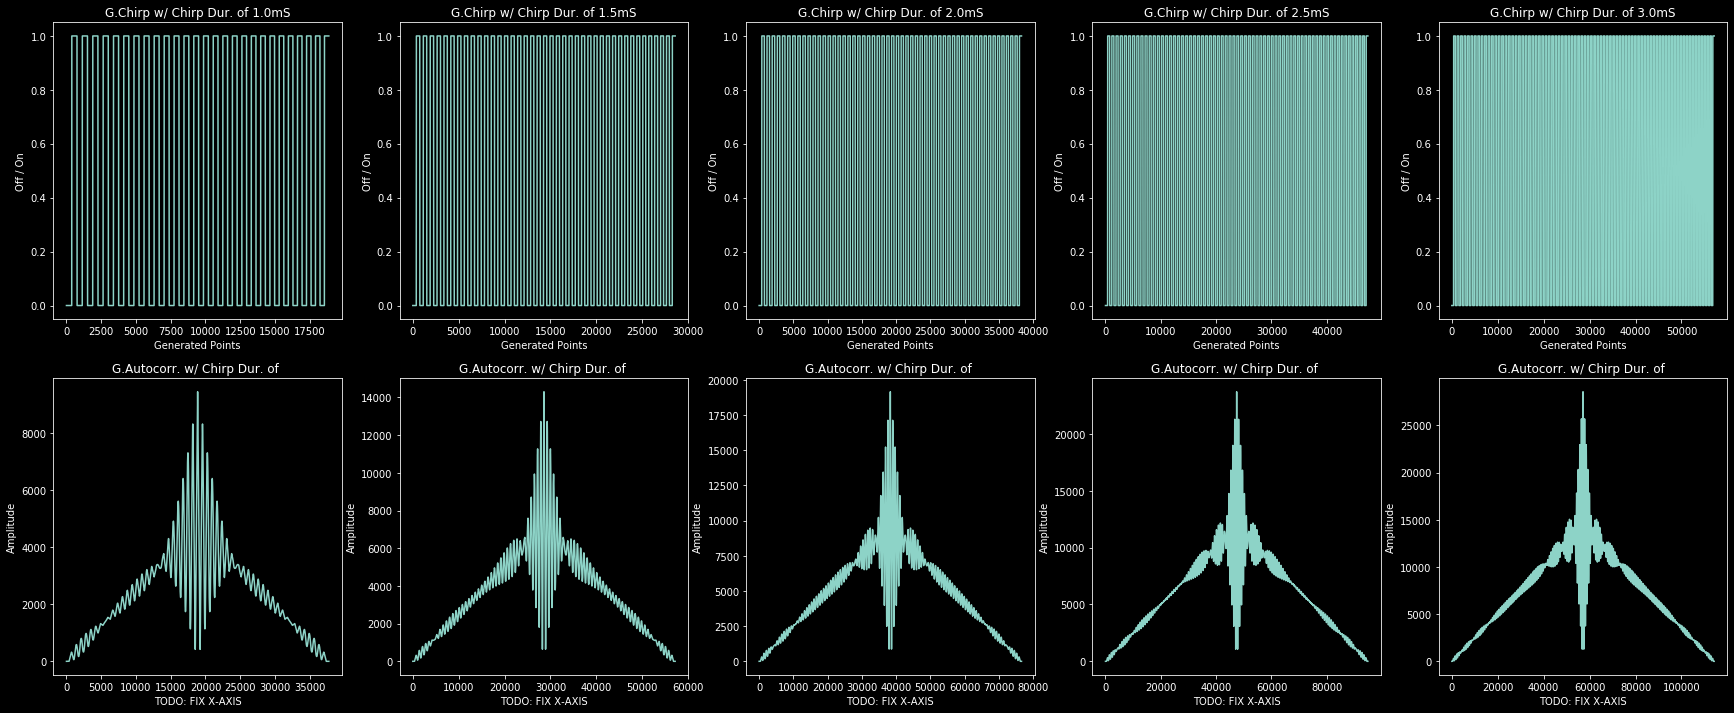

In [142]:
fig, axs = plt.subplots(2, 5, figsize=(30, 12))

for i in range(5):
    tch = 0.5e-3*i + 1e-3
    sqwave = square_chirp(19e6, 25e3, 30e3, tch)
    axs[0, i].plot(sqwave)
    axs[0, i].set_xlabel("Generated Points")
    axs[0, i].set_ylabel("Off / On")
    axs[0, i].set_title("G.Chirp w/ Chirp Dur. of " + str(tch*1000) + "mS")
    axs[1, i].plot(np.correlate(sqwave, sqwave, "full"))
    axs[1, i].set_xlabel("TODO: FIX X-AXIS")
    axs[1, i].set_ylabel("Amplitude")
    axs[1, i].set_title("G.Autocorr. w/ Chirp Dur. of ")
plt.show()